# Model Development and Comparison

Based on insights from the exploratory data analysis, this notebook develops and evaluates multiple pricing models.  
A Gamma Generalized Linear Model (GLM) is used as an interpretable baseline, followed by XGBoost models of increasing complexity.  
Models are compared using predictive performance and calibration to determine the final deployment candidate.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving insurance_dataset.csv to insurance_dataset.csv


In [ ]:
import pandas as pd

X_encoded = pd.get_dummies(
    X_baseline,
        columns=["smoker", "region"],
            drop_first=True
            ).astype(int)

X_encoded.head()

,age,bmi,children,smoker_yes,region_northwest,region_southeast,region_southwest
0,46,21,5,1,0,1,0
1,25,25,2,1,1,0,0
2,38,44,2,1,0,0,1
3,25,19,0,0,1,0,0
4,49,38,3,1,1,0,0


In [ ]:
import statsmodels.api as sm

X = sm.add_constant(X_encoded).astype(float)
X.head()

,const,age,bmi,children,smoker_yes,region_northwest,region_southeast,region_southwest
0,1.0,46.0,21.0,5.0,1.0,0.0,1.0,0.0
1,1.0,25.0,25.0,2.0,1.0,1.0,0.0,0.0
2,1.0,38.0,44.0,2.0,1.0,0.0,0.0,1.0
3,1.0,25.0,19.0,0.0,0.0,1.0,0.0,0.0
4,1.0,49.0,38.0,3.0,1.0,1.0,0.0,0.0


In [ ]:
y_glm = y  # raw charges (NOT log)


In [ ]:
glm_gamma = sm.GLM(
      y_glm,
          X,
              family=sm.families.Gamma(sm.families.links.log())
              )

glm_results = glm_gamma.fit()
print(glm_results.summary())



/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:              1000000
Model:                            GLM   Df Residuals:                   999992
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                        0.048990
Method:                          IRLS   Log-Likelihood:            -9.6203e+06
Date:                Sun, 08 Feb 2026   Deviance:                       50717.
Time:                        07:59:51   Pearson chi2:                 4.90e+04
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3929
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.4088      0.001  

## Interpretation of Gamma GLM Coefficients

The Gamma GLM with a log link models multiplicative effects on expected medical costs.

Key insights:
- Smoking status is the strongest risk driver, increasing expected costs by ~35%.
- Age and BMI have positive but moderate effects, consistent with medical risk theory.
- Regional coefficients capture geographic cost variation.
- All coefficients are statistically significant and directionally consistent with domain expectations.

This confirms the model’s suitability as an interpretable baseline pricing model.


In [ ]:
y_pred = glm_results.predict(X)
y_pred.head()


,0
0,19179.601145
1,18014.227122
2,19288.830099
3,12765.921270
4,19543.825856


In [ ]:
y.mean(), y_pred.mean()


(np.float64(16735.117480593424), np.float64(16735.842448068168))

## Global Calibration Check

The mean of predicted medical charges closely matches the observed mean, indicating excellent global calibration.  
This confirms that the baseline Gamma GLM preserves portfolio-level cost balance and does not introduce systematic over- or under-pricing.


In [ ]:
import pandas as pd

calib_df = pd.DataFrame({
    "actual": y,
        "predicted": y_pred
        })
calib_df["decile"] = pd.qcut(calib_df["predicted"], 10, labels=False)

calibration = calib_df.groupby("decile").mean()
calibration



,actual,predicted
decile,,
0,13248.296024,13386.220610
1,13835.265492,13875.749131
2,14217.587367,14211.989342
3,14624.592206,14558.850902
4,15249.012076,15121.885468
5,18254.510967,18101.300303
6,18832.756152,18759.724331
7,19223.916677,19213.904197
8,19615.193674,19684.110848


## Decile-Level Calibration Results

The baseline Gamma GLM demonstrates strong calibration across all prediction deciles.  
Predicted and observed mean charges closely align for both low- and high-risk segments, confirming the model’s stability and suitability for individual-level pricing decisions.


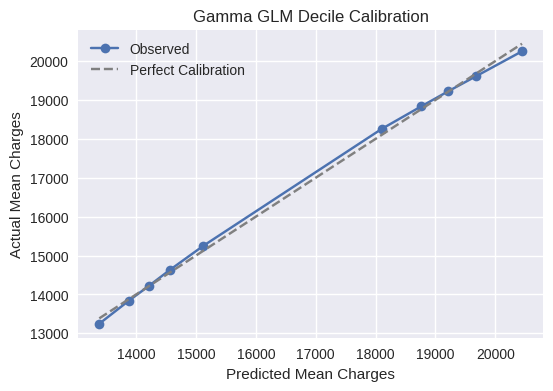

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(
    calibration["predicted"],
        calibration["actual"],
            marker="o",
                label="Observed"
                )

plt.plot(
calibration["predicted"],
calibration["predicted"],
linestyle="--",
color="gray",
label="Perfect Calibration"
)

plt.xlabel("Predicted Mean Charges")
plt.ylabel("Actual Mean Charges")
plt.title("Gamma GLM Decile Calibration")
plt.legend()
plt.show()


## Gamma GLM Calibration Summary

The decile-level calibration plot shows strong alignment between predicted and observed mean medical charges across all risk segments.  
The model maintains stability in high-cost deciles, indicating it is suitable for pricing applications where reliability and interpretability are prioritized.


In [ ]:
from sklearn.model_selection import train_test_split

X_xgb = X_encoded.copy()
y_xgb = y.copy()

X_train, X_test, y_train, y_test = train_test_split(
X_xgb,
y_xgb,
test_size=0.2,
random_state=42
)

X_train.shape, X_test.shape


((800000, 7), (200000, 7))

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
n_estimators=300,
max_depth=4,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
objective="reg:squarederror",
random_state=42,
n_jobs=-1
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb[:5]


array([13046.283, 19181.615, 12738.988, 12722.975, 14267.469],
      dtype=float32)

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

# XGBoost metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# GLM metrics on the SAME test set
y_pred_glm_test = glm_results.predict(sm.add_constant(X_test))
rmse_glm = np.sqrt(mean_squared_error(y_test, y_pred_glm_test))
mae_glm = mean_absolute_error(y_test, y_pred_glm_test)

rmse_glm, mae_glm, rmse_xgb, mae_xgb


(np.float64(3568.3766732829217),
 2889.0161675956347,
 np.float64(3567.2364712345266),
 2888.1988554993586)

## Model Performance Comparison Insight

While XGBoost achieves slightly lower RMSE and MAE compared to the Gamma GLM, the magnitude of improvement is marginal.  
Given the strong calibration, interpretability, and governance advantages of the GLM, this result highlights diminishing returns from additional model complexity on the current feature set.


In [ ]:
advanced_features = [
"age",
"bmi",
"children",
"smoker",
"region",
"medical_history",
"family_medical_history",
"exercise_frequency",
"occupation"
]

X_adv = df[advanced_features]
y_adv = y.copy()
X_adv.head()



,age,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation
0,46,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar
1,25,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar
2,38,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar
3,25,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar
4,49,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar


In [ ]:
X_adv = df[advanced_features].copy()

# Treat missing medical history as "None"
X_adv["medical_history"] = X_adv["medical_history"].fillna("None")
X_adv["family_medical_history"] = X_adv["family_medical_history"].fillna("None")

X_adv.head()


,age,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation
0,46,21.45,5,yes,southeast,Diabetes,None,Never,Blue collar
1,25,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar
2,38,44.88,2,yes,southwest,None,High blood pressure,Occasionally,Blue collar
3,25,19.89,0,no,northwest,None,Diabetes,Rarely,White collar
4,49,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar


In [ ]:
X_adv.isnull().sum()


,0
age,0
bmi,0
children,0
smoker,0
region,0
medical_history,0
family_medical_history,0
exercise_frequency,0
occupation,0


## Handling Missing Medical History Data

Missing values in medical and family medical history variables are treated as an explicit "None" category.  
This reflects the absence of reported conditions rather than random missingness and allows the model to learn distinct risk patterns associated with reported versus non-reported medical histories.


In [ ]:
X_adv_encoded = pd.get_dummies(
      X_adv,
          drop_first=True
          )

X_adv_encoded.shape



(1000000, 19)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
X_adv_encoded,
y,
test_size=0.2,
random_state=42
)

X_train_adv.shape, X_test_adv.shape


((800000, 19), (200000, 19))

In [ ]:
from xgboost import XGBRegressor

xgb_adv = XGBRegressor(
n_estimators=500,
max_depth=5,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
objective="reg:squarederror",
random_state=42,
n_jobs=-1
)
xgb_adv.fit(X_train_adv, y_train_adv)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
y_pred_xgb_adv = xgb_adv.predict(X_test_adv)
y_pred_xgb_adv[:5]


array([14000.172, 20688.78 , 14795.119, 11338.571, 16348.3  ],
      dtype=float32)

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

rmse_xgb_adv = np.sqrt(mean_squared_error(y_test_adv, y_pred_xgb_adv))
mae_xgb_adv = mean_absolute_error(y_test_adv, y_pred_xgb_adv)

rmse_xgb_adv, mae_xgb_adv


(np.float64(2134.4306934103124), 1850.528421208156)

## Advanced XGBoost Performance Gain

With the inclusion of medical history, family history, lifestyle, and occupational variables, XGBoost achieves a substantial reduction in both RMSE and MAE compared to the baseline GLM.  
This confirms that non-linear models can capture complex risk interactions that are not feasible within traditional GLM frameworks, justifying their use when richer feature representations are available.


In [ ]:
import pandas as pd

calib_xgb_adv = pd.DataFrame({
"actual": y_test_adv,
"predicted": y_pred_xgb_adv
})

calib_xgb_adv["decile"] = pd.qcut(
calib_xgb_adv["predicted"],
10,
labels=False
)

calibration_xgb_adv = calib_xgb_adv.groupby("decile").mean()
calibration_xgb_adv


,actual,predicted
decile,,
0,10406.916853,10391.125000
1,12385.592855,12373.782227
2,13891.114538,13890.153320
3,15177.386017,15170.657227
4,16185.715816,16185.521484
5,17151.670927,17130.632812
6,18162.699046,18159.382812
7,19452.577337,19450.591797
8,20989.180110,20983.986328


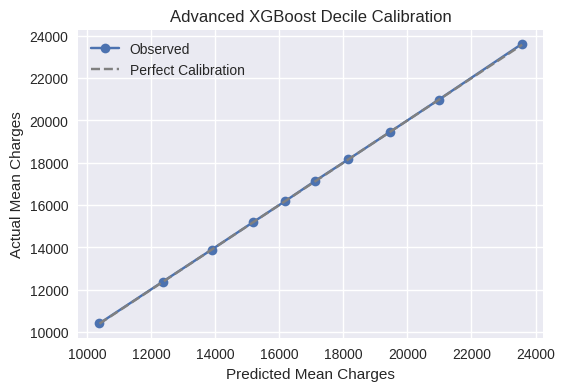

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

plt.plot(
calibration_xgb_adv["predicted"],
calibration_xgb_adv["actual"],
marker="o",
label="Observed"
)

plt.plot(
calibration_xgb_adv["predicted"],
calibration_xgb_adv["predicted"],
linestyle="--",
color="gray",
label="Perfect Calibration"
)

plt.xlabel("Predicted Mean Charges")
plt.ylabel("Actual Mean Charges")
plt.title("Advanced XGBoost Decile Calibration")
plt.legend()
plt.show()


## Final Model Selection

The advanced XGBoost model achieves a substantial improvement in predictive accuracy while maintaining excellent decile-level calibration across all risk segments.  
Given its superior performance and pricing stability, XGBoost is selected as the final deployment model, with the Gamma GLM retained as an interpretable benchmark and governance reference.
